# Import libraries

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Read file

In [2]:
df = pl.read_excel('./datasets/Customer-Churn.xlsx').lazy()

In [3]:
# The analysis on how encoding was based is down on EDA analysis - Data Glossary, for now only going to be used on EDA

# Numeric columns
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']
# Maximum three options on the yes_no_columns
yes_no_cols = [
    'Partner', 'Dependents', 'PhoneService', 'MultipleLines','OnlineSecurity', 'OnlineBackup', 
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling'
]

# Can convert to dummy columns
dummies = ['PaymentMethod', 'gender', 'InternetService']

# Ordinal columns 'Contract' 

# Target 'Churn'

# Columns dropped because of cardinality - 'customerID'


df.fetch(5)

customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
str,str,i64,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str
"""7569-NMZYQ""","""Female""",0,"""Yes""","""Yes""",72,"""Yes""","""Yes""","""Fiber optic""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""Two year""","""Yes""","""Bank transfer …",118.75,8672.45,"""No"""
"""8984-HPEMB""","""Female""",0,"""No""","""No""",71,"""Yes""","""Yes""","""Fiber optic""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""Two year""","""Yes""","""Electronic che…",118.65,8477.6,"""No"""
"""5989-AXPUC""","""Female""",0,"""Yes""","""No""",68,"""Yes""","""Yes""","""Fiber optic""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""Two year""","""No""","""Mailed check""",118.6,7990.05,"""No"""
"""5734-EJKXG""","""Female""",0,"""No""","""No""",61,"""Yes""","""Yes""","""Fiber optic""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""One year""","""Yes""","""Electronic che…",118.6,7365.7,"""No"""
"""8199-ZLLSA""","""Male""",0,"""No""","""No""",67,"""Yes""","""Yes""","""Fiber optic""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""One year""","""Yes""","""Bank transfer …",118.35,7804.15,"""Yes"""


In [4]:
# Yes/No columns conversion

yes_no_df = pl.concat([
    df.select(
        pl.when(
            pl.col(x) == 'Yes'
        ).then(
            2
        ).when(
            pl.col(x) == 'No'
        ).then(
            1
        ).otherwise(
            0
        ).cast(
            pl.Int8
        ).alias(x)
    ) for x in yes_no_cols
],
    how='horizontal'
).collect()

In [5]:
# Ordinal column conversion

ordinal_col = df.select(
    pl.col(
        'Contract'
    ).replace({
        'Month-to-month': 0,
        'One year': 1,
        'Two year': 2
    }).cast(pl.Int8)
).collect()

In [6]:
# Target

target = df.select(
    pl.when(
        pl.col('Churn') == 'Yes'
    ).then(
        1
    ).otherwise(
        0
    ).cast(
        pl.Int8
    ).alias('target')
).collect()

In [7]:
df_numeric = pl.concat([
    df.select(numeric_cols).collect(),

    yes_no_df,

    ordinal_col,

    df.select(
        dummies
    ).collect(
    ).to_dummies(
    ).cast(pl.Int8),

    target
    
],
    how='horizontal')

In [8]:
df_numeric.head(5)

tenure,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,Contract,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Female,gender_Male,InternetService_DSL,InternetService_Fiber optic,InternetService_No,target
i64,f64,f64,i64,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
72,118.75,8672.45,0,2,2,2,2,2,2,2,2,2,2,2,2,1,0,0,0,1,0,0,1,0,0
71,118.65,8477.6,0,1,1,2,2,2,2,2,2,2,2,2,2,0,0,1,0,1,0,0,1,0,0
68,118.6,7990.05,0,2,1,2,2,2,2,2,2,2,2,1,2,0,0,0,1,1,0,0,1,0,0
61,118.6,7365.7,0,1,1,2,2,2,2,2,2,2,2,2,1,0,0,1,0,1,0,0,1,0,0
67,118.35,7804.15,0,1,1,2,2,2,2,2,2,2,2,2,1,1,0,0,0,0,1,0,1,0,1


# EDA

In [9]:
# Shape of data
df.collect().shape

(7043, 21)

In [10]:
# Sample of rows
df.fetch(5)

customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
str,str,i64,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str
"""7569-NMZYQ""","""Female""",0,"""Yes""","""Yes""",72,"""Yes""","""Yes""","""Fiber optic""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""Two year""","""Yes""","""Bank transfer …",118.75,8672.45,"""No"""
"""8984-HPEMB""","""Female""",0,"""No""","""No""",71,"""Yes""","""Yes""","""Fiber optic""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""Two year""","""Yes""","""Electronic che…",118.65,8477.6,"""No"""
"""5989-AXPUC""","""Female""",0,"""Yes""","""No""",68,"""Yes""","""Yes""","""Fiber optic""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""Two year""","""No""","""Mailed check""",118.6,7990.05,"""No"""
"""5734-EJKXG""","""Female""",0,"""No""","""No""",61,"""Yes""","""Yes""","""Fiber optic""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""One year""","""Yes""","""Electronic che…",118.6,7365.7,"""No"""
"""8199-ZLLSA""","""Male""",0,"""No""","""No""",67,"""Yes""","""Yes""","""Fiber optic""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""One year""","""Yes""","""Bank transfer …",118.35,7804.15,"""Yes"""


In [11]:
# Mild imbalanced dataset https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data#:~:text=A%20classification%20data%20set%20with,smaller%20proportion%20are%20minority%20classes.
df.select(
    'Churn'
).collect(
).to_pandas(
).value_counts(normalize=True)

Churn
No       0.73463
Yes      0.26537
Name: proportion, dtype: float64

In [12]:
# Unique values

for col in df.columns:
    col_analysis = df.select(col).unique()
    print(f'''
    {col}:\
    {col_analysis.head(5).collect()[col].to_list()}
    Unique values: {col_analysis.collect().shape[0]}
    ''')


    customerID:    ['4718-WXBGI', '9048-JVYVF', '0526-SXDJP', '5129-HHMZC', '9350-VLHMB']
    Unique values: 7043
    

    gender:    ['Female', 'Male']
    Unique values: 2
    

    SeniorCitizen:    [0, 1]
    Unique values: 2
    

    Partner:    ['No', 'Yes']
    Unique values: 2
    

    Dependents:    ['Yes', 'No']
    Unique values: 2
    

    tenure:    [12, 9, 45, 6, 36]
    Unique values: 73
    

    PhoneService:    ['No', 'Yes']
    Unique values: 2
    

    MultipleLines:    ['Yes', 'No', 'No phone service']
    Unique values: 3
    

    InternetService:    ['Fiber optic', 'No', 'DSL']
    Unique values: 3
    

    OnlineSecurity:    ['No', 'No internet service', 'Yes']
    Unique values: 3
    

    OnlineBackup:    ['Yes', 'No', 'No internet service']
    Unique values: 3
    

    DeviceProtection:    ['Yes', 'No', 'No internet service']
    Unique values: 3
    

    TechSupport:    ['Yes', 'No internet service', 'No']
    Unique values: 3
    

    Streaming

### Data Glossary
- customerID: Customer ID - High Cardinality

- gender: Male or Female - Possible dummy conversion

- SeniorCitizen: Senior Citizen? - Yes/No/Other column

- Partner: Any partner? - Yes/No/Other column

- Dependents: Any dependents? - Yes/No/Other column

- tenure: Number of days/months/year with the company (probably months)

- PhoneService: Any phone service? - Yes/No/Other column

- MultipleLines: Does him/her have multiple lines? - Yes/No/Other column

- InternetService: Service provider - Yes/No/Other column 

- OnlineSecurity: Any Online Security? - Yes/No/Other column

- OnlineBackup: Any Online Security? - Yes/No/Other column

- DeviceProtection: Any Device Protection? - Yes/No/Other column

- TechSupport: Any Tech Support? - Yes/No/Other column

- StreamingTV: Any Streaming TV service? - Yes/No/Other column

- StreamingMovies: Any Streaming Movie service? - Yes/No/Other column

- Contract: What kind of contract? - Three option contract, based on time.

- PaperlessBilling: Paperless billing chosen? - Yes/No/Other column

- PaymentMethod: What kind of Payment Method?

- MonthlyCharges: Amount charged each month

- TotalCharges: Total amount charged since the beginning of the service

- Churn: Is churn?

In [13]:
# General statistics with no data cleaning in order to not leak information.

df.collect().describe()

statistic,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
str,str,str,f64,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str
"""count""","""7043""","""7043""",7043.0,"""7043""","""7043""",7043.0,"""7043""","""7043""","""7043""","""7043""","""7043""","""7043""","""7043""","""7043""","""7043""","""7043""","""7043""","""7043""",7043.0,7032.0,"""7043"""
"""null_count""","""0""","""0""",0.0,"""0""","""0""",0.0,"""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,11.0,"""0"""
"""mean""",null,null,0.162147,null,null,32.371149,null,null,null,null,null,null,null,null,null,null,null,null,64.761692,2283.300441,null
"""std""",null,null,0.368612,null,null,24.559481,null,null,null,null,null,null,null,null,null,null,null,null,30.090047,2266.771362,null
"""min""","""0002-ORFBO""","""Female""",0.0,"""No""","""No""",0.0,"""No""","""No""","""DSL""","""No""","""No""","""No""","""No""","""No""","""No""","""Month-to-month…","""No""","""Bank transfer …",18.25,18.8,"""No"""
"""25%""",null,null,0.0,null,null,9.0,null,null,null,null,null,null,null,null,null,null,null,null,35.5,401.5,null
"""50%""",null,null,0.0,null,null,29.0,null,null,null,null,null,null,null,null,null,null,null,null,70.35,1397.65,null
"""75%""",null,null,0.0,null,null,55.0,null,null,null,null,null,null,null,null,null,null,null,null,89.85,3794.5,null
"""max""","""9995-HOTOH""","""Male""",1.0,"""Yes""","""Yes""",72.0,"""Yes""","""Yes""","""No""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""Two year""","""Yes""","""Mailed check""",118.75,8684.8,"""Yes"""


In [14]:
# Missing Data
df.collect(
).to_pandas(
).isnull(
).sum(
) / df.select(
'customerID'
).count(
).collect()[0,0]

# As there are few missing rows, we are going to create a function to fill them later

customerID          0.000000
gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
tenure              0.000000
PhoneService        0.000000
MultipleLines       0.000000
InternetService     0.000000
OnlineSecurity      0.000000
OnlineBackup        0.000000
DeviceProtection    0.000000
TechSupport         0.000000
StreamingTV         0.000000
StreamingMovies     0.000000
Contract            0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
TotalCharges        0.001562
Churn               0.000000
dtype: float64

### Visual Inspection

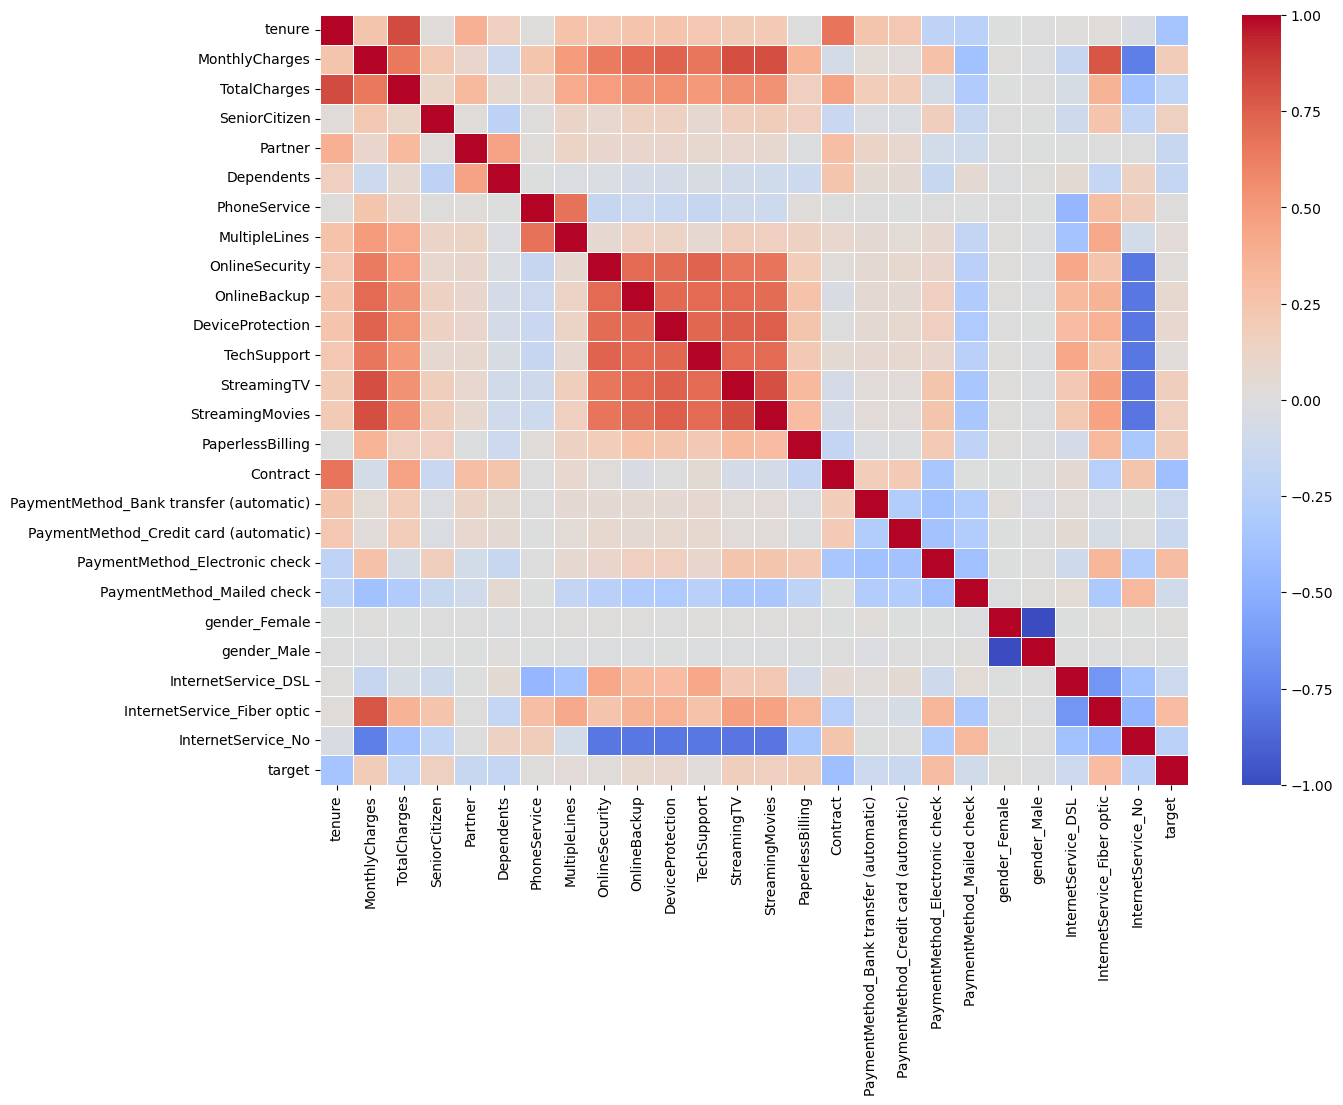

In [15]:
plt.figure(figsize=(14, 10))

# Pearson correlation
sns.heatmap(df_numeric.to_pandas().corr(), cmap='coolwarm', linewidths=0.5);

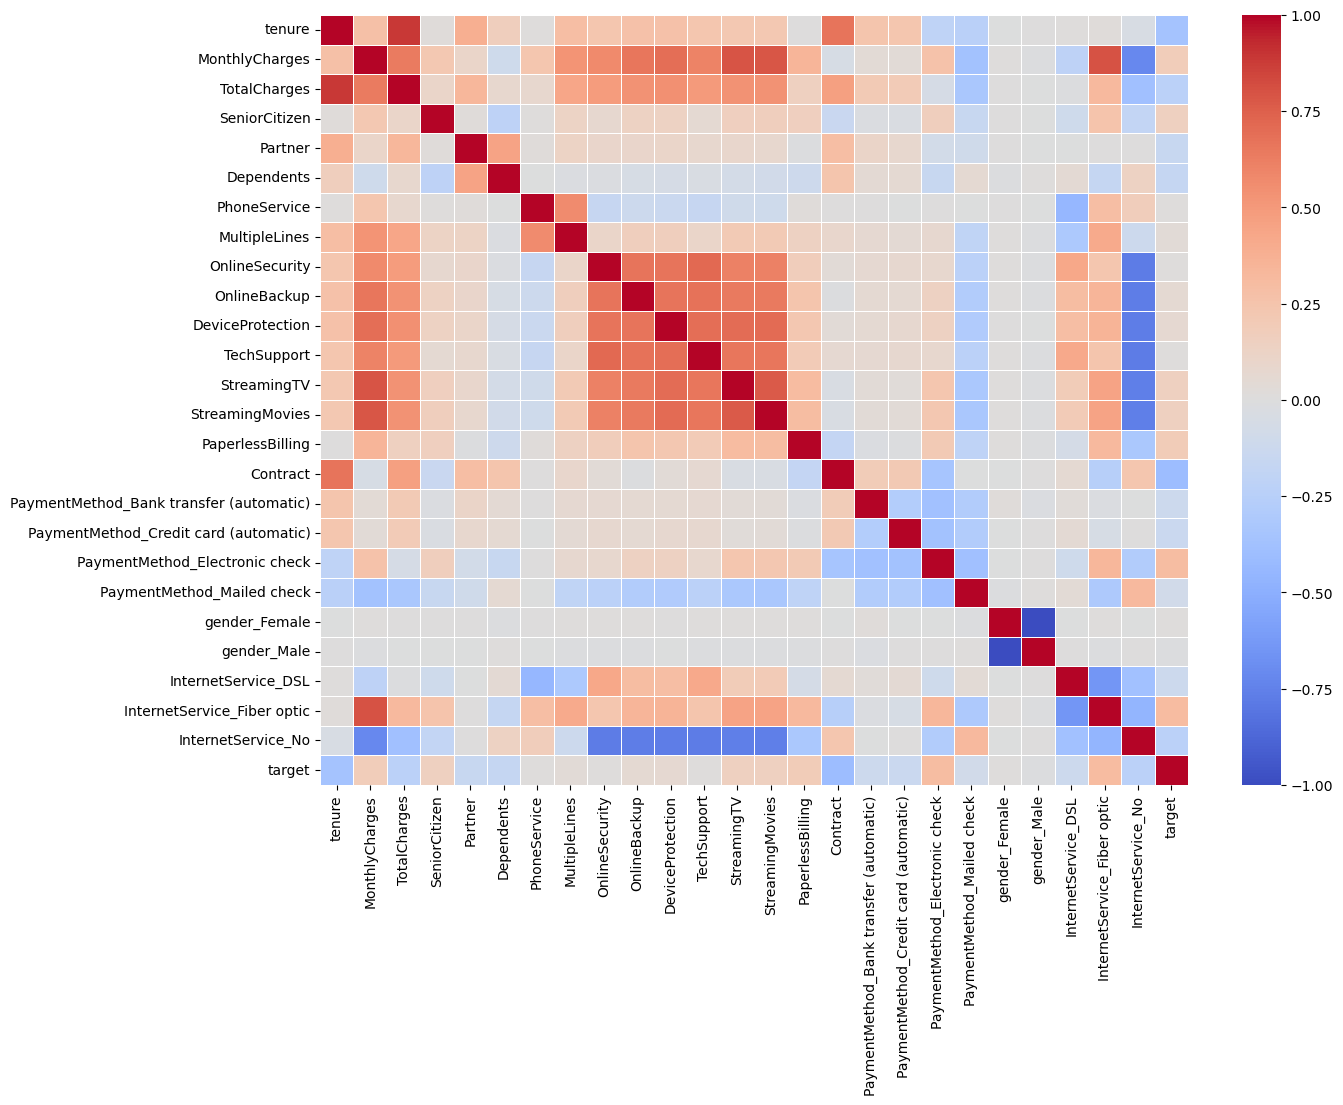

In [16]:
plt.figure(figsize=(14, 10))

#Spearman correlation - quite similar of the previous
spearman_corr = df_numeric.to_pandas().corr('spearman')
sns.heatmap(spearman_corr , cmap='coolwarm', linewidths=0.5);

In [17]:
# Auxiliary function to filter correlations and analyze them

def spearman_corr_filter(column_analyze):

    return pl.DataFrame(
        spearman_corr.reset_index()
    ).melt(
        id_vars=['index'],
        value_vars=spearman_corr.columns
    ).filter(
        (pl.col('index') != pl.col('variable')) &
        (pl.col('index') == column_analyze)
    ).drop(
        'index'
    ).sort(
        'value'
    ).to_pandas(

    )

In [18]:
spearman_corr_filter('tenure')

,variable,value
0,target,-0.367062
1,PaymentMethod_Mailed check,-0.239293
2,PaymentMethod_Electronic check,-0.209206
3,InternetService_No,-0.040604
4,gender_Female,-0.003486
5,gender_Male,0.003486
6,PaperlessBilling,0.007695
7,PhoneService,0.008483
8,InternetService_DSL,0.011718
9,SeniorCitizen,0.018556


In [19]:
spearman_corr_filter('MonthlyCharges')

,variable,value
0,InternetService_No,-0.711107
1,PaymentMethod_Mailed check,-0.374151
2,InternetService_DSL,-0.218277
3,Dependents,-0.107011
4,Contract,-0.048828
5,gender_Male,-0.013736
6,gender_Female,0.013736
7,PaymentMethod_Credit card (automatic),0.033042
8,PaymentMethod_Bank transfer (automatic),0.045927
9,Partner,0.108463


In [20]:
spearman_corr_filter('TotalCharges')

,variable,value
0,InternetService_No,-0.386042
1,PaymentMethod_Mailed check,-0.333346
2,target,-0.232190
3,PaymentMethod_Electronic check,-0.060037
4,InternetService_DSL,-0.007913
5,gender_Male,-0.001177
6,gender_Female,0.001177
7,Dependents,0.082890
8,PhoneService,0.084910
9,SeniorCitizen,0.107248


In [21]:
spearman_corr_filter('target')

,variable,value
0,Contract,-0.406262
1,tenure,-0.367062
2,TotalCharges,-0.232190
3,InternetService_No,-0.227890
4,Dependents,-0.164221
5,Partner,-0.150448
6,PaymentMethod_Credit card (automatic),-0.134302
7,InternetService_DSL,-0.124214
8,PaymentMethod_Bank transfer (automatic),-0.117937
9,PaymentMethod_Mailed check,-0.091683


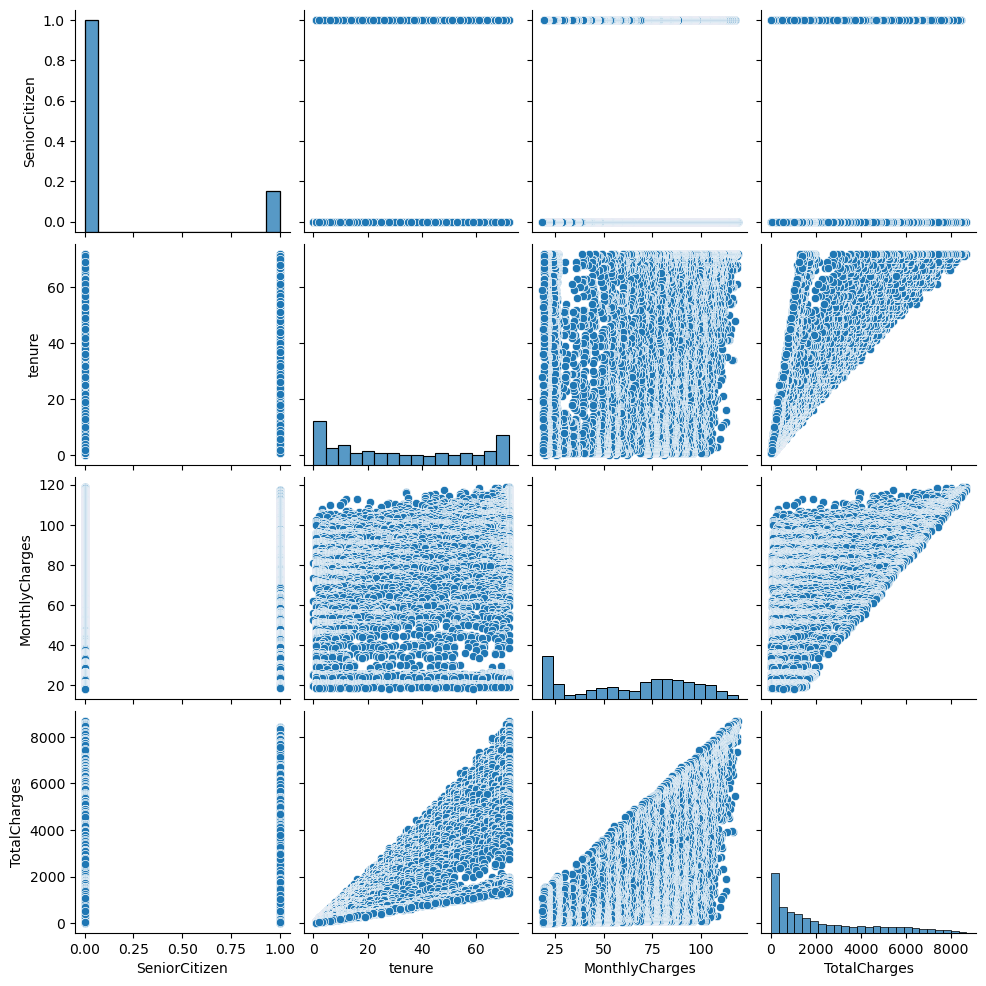

In [22]:
# Pairplot  analysis of the first numeric columns

sns.pairplot(df.collect(
).drop(
    'Senior Citizen'
).to_pandas()
);

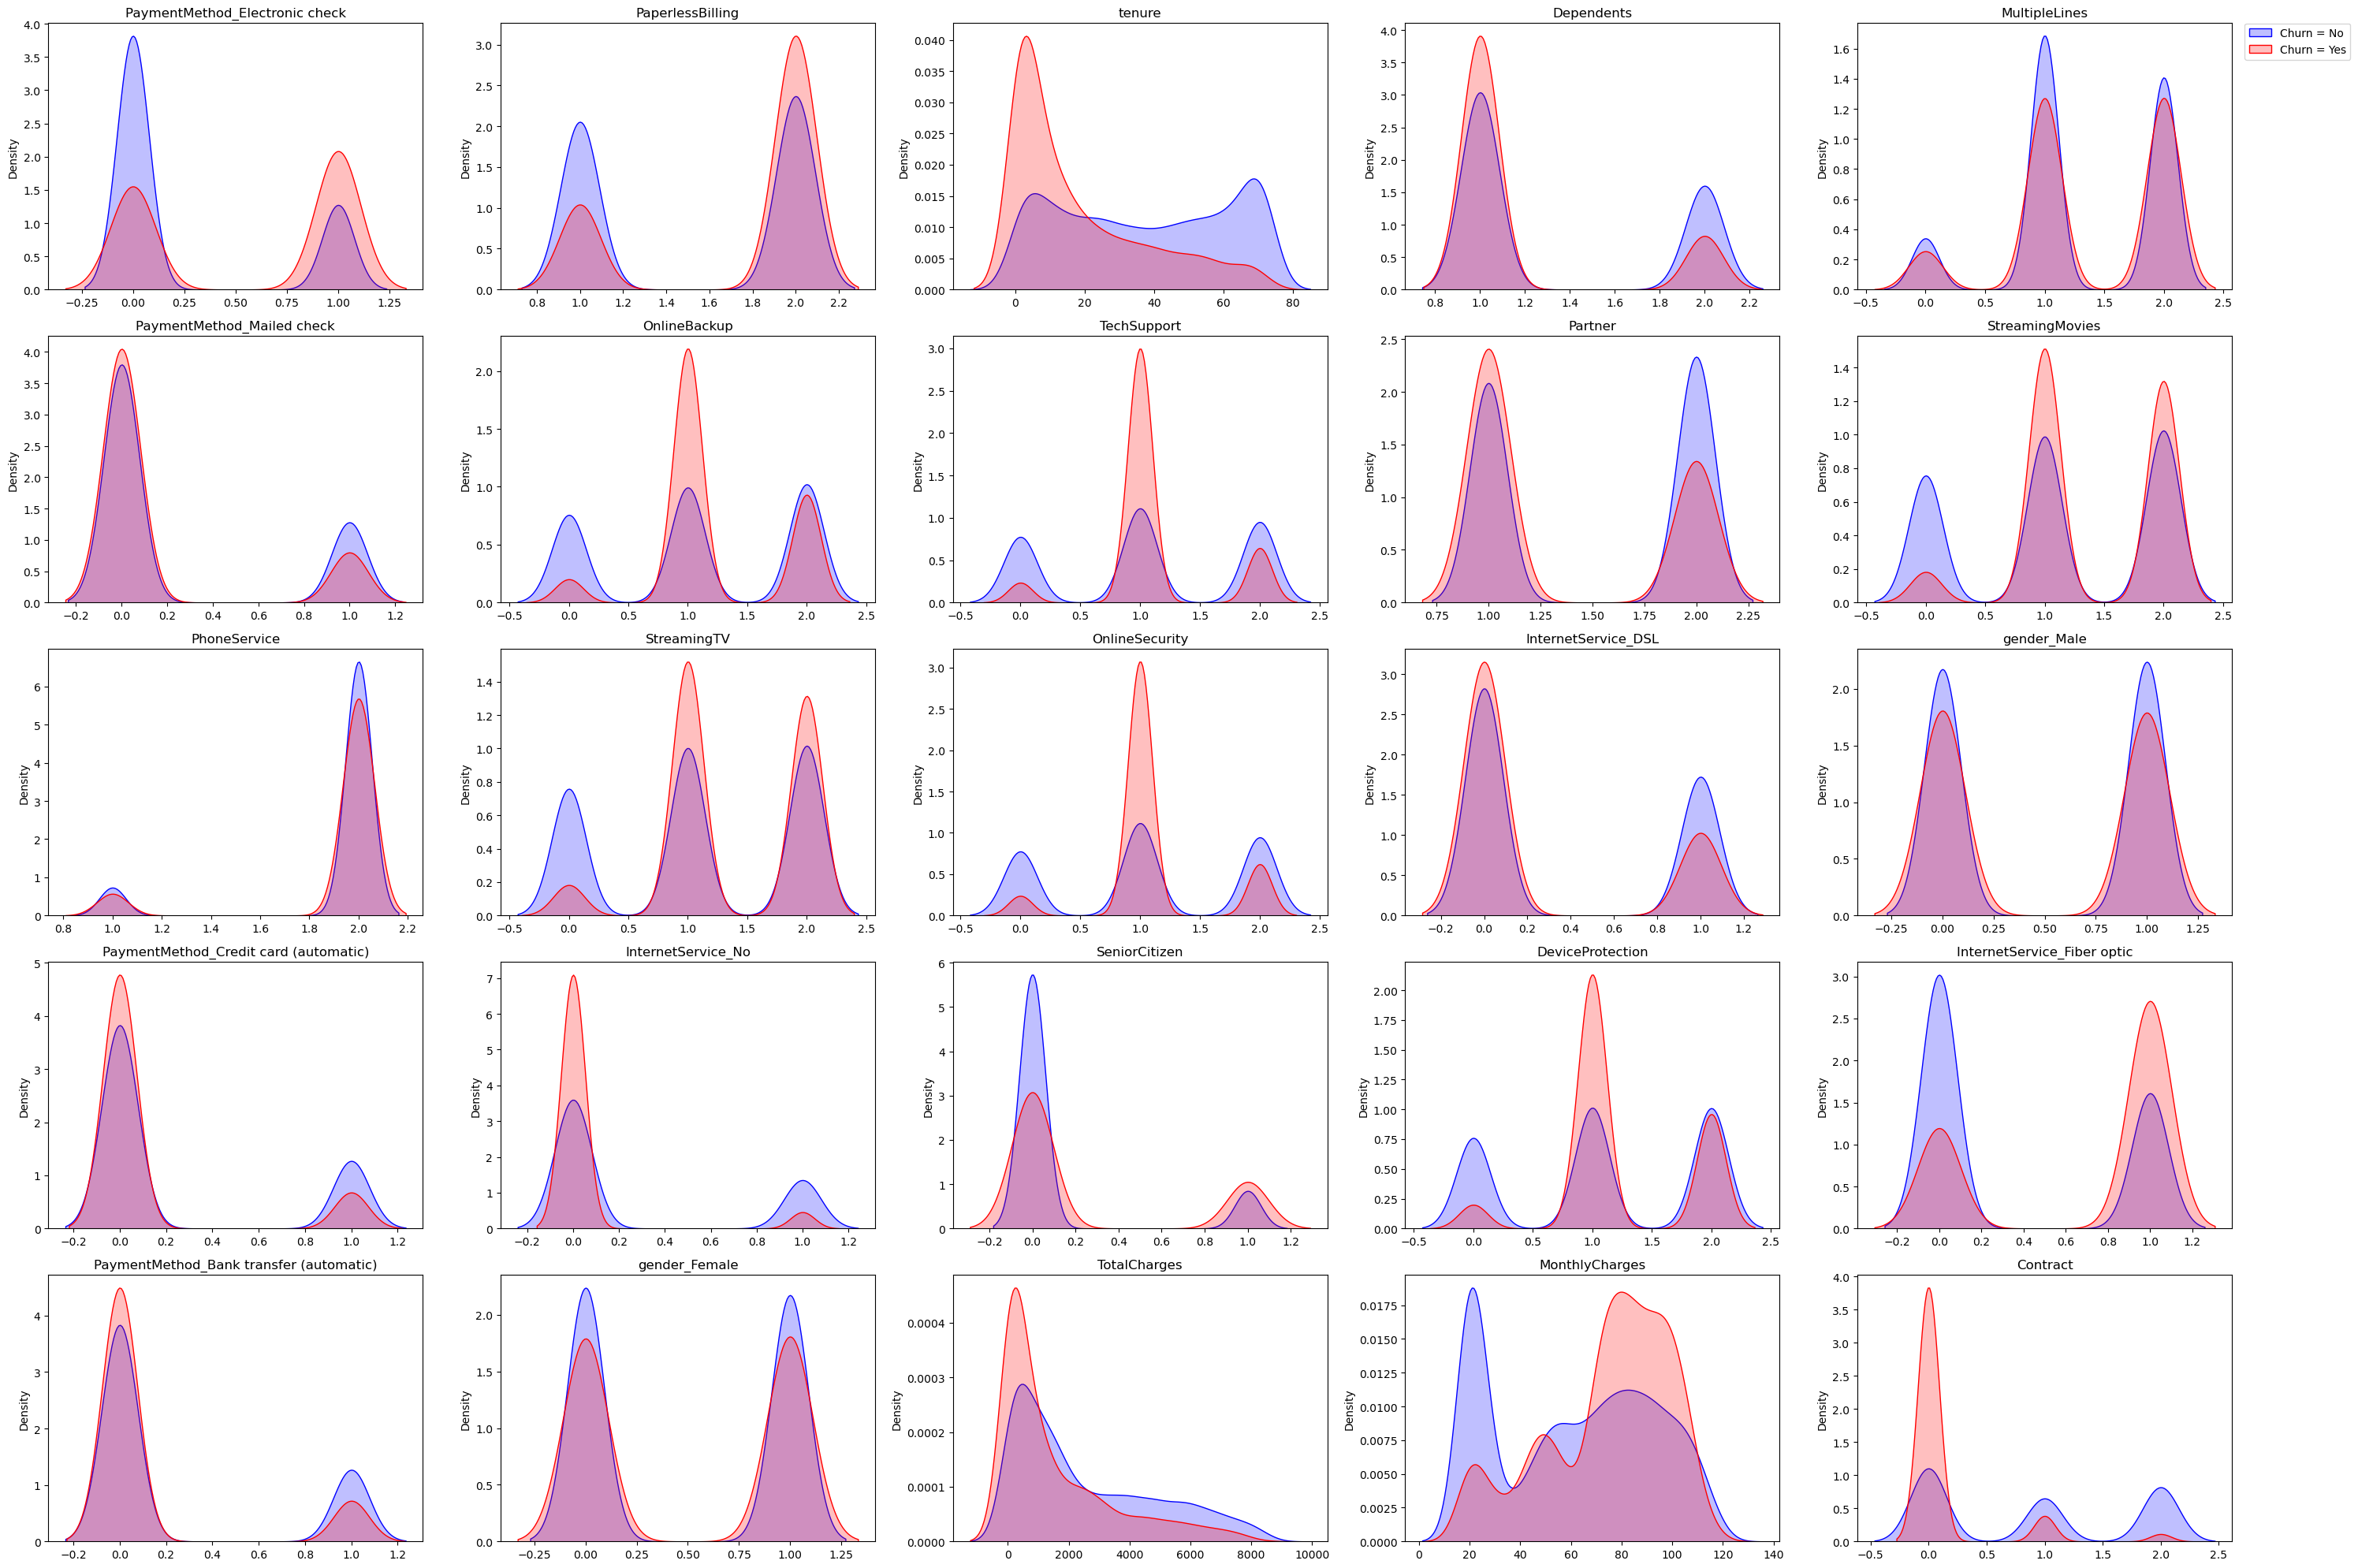

In [23]:
# Density analysis

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(30, 20))

plot = 0

columns_plot = list(set(df_numeric.columns) - set(['target']))

for row in ax:

    for col in range(5):

        sns.kdeplot(data = df_numeric.filter(pl.col('target') == 0)[columns_plot[plot]].to_list(), ax=row[col],label='Churn = No',fill=True, color='blue')
        sns.kdeplot(data = df_numeric.filter(pl.col('target') == 1)[columns_plot[plot]].to_list(), ax=row[col],label='Churn = Yes',fill=True, color='red', )
        row[col].title.set_text(columns_plot[plot])
        plot += 1


ax[0][4].legend(bbox_to_anchor=(1.02, 1.02), loc='upper left')
plt.tight_layout()
plt.show()

In [24]:
# Scatterplot to analyze the relationship between MonthlyCharges, TotalCharges (so we are considering ternure as well) and Churn.

px.scatter(
    df.select([
    'Churn',
    'MonthlyCharges',
    'TotalCharges'
]).collect().to_pandas(),
x='MonthlyCharges',
y='TotalCharges',
color='Churn'
)

# Insights

In [52]:
# Data to base our insights

df.filter(
    pl.col('Churn') == 'Yes'
).group_by([
    (pl.col('tenure') // 10)
]).len(
).sort(
    'tenure'
).with_columns([
    (pl.col('len') / pl.col('len').sum()).round(2)
]).with_columns([
    pl.col('len').cum_sum().alias('cumsum')
]).collect()

tenure,len,cumsum
i64,f64,f64
0,0.49,0.49
1,0.17,0.66
2,0.09,0.75
3,0.08,0.83
4,0.06,0.89
5,0.05,0.94
6,0.04,0.98
7,0.01,0.99


In [53]:
df.filter(
    pl.col('Churn') == 'Yes'
).group_by([
    'Contract'
]).len(
).with_columns([
    (pl.col('len') / pl.col('len').sum()).round(2)
]).collect()

Contract,len
str,f64
"""Month-to-month…",0.89
"""One year""",0.09
"""Two year""",0.03


In [65]:
df.filter(
    pl.col('Churn') == 'Yes'
).with_columns([
    pl.col('MonthlyCharges') // 20
]).group_by([
    'MonthlyCharges'
]).len(
).sort(
    'MonthlyCharges', descending=True
).with_columns([
    (pl.col('len') / pl.col('len').sum()).round(2)
]).with_columns([
    pl.col('len').cum_sum().alias('cumsum')
]).collect()

MonthlyCharges,len,cumsum
f64,f64,f64
5.0,0.14,0.14
4.0,0.35,0.49
3.0,0.25,0.74
2.0,0.15,0.89
1.0,0.08,0.97
0.0,0.03,1.0


- We have no correlation in gender with any other data. Even thought it had, it could provide harmful bias, so we will not consider it in our Machine Learning model.


- We perceived the following characteristics of churn:

    - Recent clients. (45% below 10 months)

    - Month-to-month contracts. (89%)

    - High Monthly Charge services in the beginning of the relationship with the company. (74% above USD 60 monthly charges)

    - And not using other services that is correlated with heavy internet users (Online Security, Tech Support, Online Backup, etc.).

# Split for Machine Learning training and validation

In [54]:
from sklearn.model_selection import train_test_split

X, y = df_numeric.select(
    list(set(df_numeric.columns) - set(['target', 'customerID','gender']))
) , df_numeric.select(
    pl.col('target')
)


train,to_split_X,train_y,to_split_y = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

In [55]:
validation,test,validation_y,test_y = train_test_split(to_split_X,to_split_y, test_size=0.4, random_state=42, stratify=to_split_y)

In [56]:
# Proportions of train, validation and test
print(
    f' Train: {round(train.shape[0]/X.shape[0]*100)}%\n',
    f'Validation: {round(validation.shape[0]/X.shape[0]*100)}%\n', 
    f'Test: {round(test.shape[0]/X.shape[0]*100)}%\n'
)

 Train: 80%
 Validation: 12%
 Test: 8%



In [57]:
# Checking if the stratified split went well

print('Train: Proportions of Churn')
print(
train_y.to_pandas(

).value_counts(normalize=True)
, '\n')
print('Validation: Proportions of Churn')
print(
validation_y.to_pandas(

).value_counts(normalize=True)
, '\n')
print('Test: Proportions of Churn')
print(
test_y.to_pandas(

).value_counts(normalize=True)
)

Train: Proportions of Churn
target
0         0.734647
1         0.265353
Name: proportion, dtype: float64 

Validation: Proportions of Churn
target
0         0.734911
1         0.265089
Name: proportion, dtype: float64 

Test: Proportions of Churn
target
0         0.734043
1         0.265957
Name: proportion, dtype: float64


In [58]:
# Saving dataframes
for df_saves in {
    'X_train':train,
    'X_val':validation,
    'X_test':test,
    'y_train':train_y,
    'y_val':validation_y,
    'y_test':test_y
 }.items():
    df_saves[1].write_parquet(f'./datasets/{df_saves[0]}.parquet')